In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style('darkgrid')
import shutil

import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

In [ ]:
train_ds = ImageFolder(root='../input/tomato-disease-multiple-sources/train', transform=T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]))
test_ds = ImageFolder(root='../input/tomato-disease-multiple-sources/valid', transform=T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]))

print("Train:", len(train_ds))
print("Test:", len(test_ds))

In [ ]:
classes = os.listdir('../input/tomato-disease-multiple-sources/train')
classes = [file.replace(' ', '_') for file in classes]
print(classes)
print(len(classes))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(train_ds, batch_size=128, shuffle=False)

In [ ]:
from torchvision.models import mobilenet_v3_small, mobilenet_v2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mobilenet_v3_small(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model._modules['classifier'][-1].in_features
out_features = len(classes)
model._modules['classifier'][-1] = nn.Linear(in_features, out_features, bias=True)
model._modules['classifier'][0].requires_grad = True
model._modules['classifier'][-1].requires_grad = True
model = model.to(device)

In [ ]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=0.01)
# scheduler = OneCycleLR(opt, max_lr=1, epochs=num_epochs, steps_per_epoch=len(train_dl))

In [ ]:
calc_params = lambda model: f'{sum(p.numel() for p in model.parameters()) // 1e6}M'
calc_params(model)

In [ ]:
acc = torchmetrics.Accuracy(num_classes=len(classes)).to(device)
f1 = torchmetrics.F1Score(num_classes=len(classes), average='weighted').to(device)

In [ ]:
def train(model, criterion, opt, dataloader, scheduler=None):
    model.train()
    
    total_loss = 0.0
    accuracy = 0.0
    f1_score = 0.0
    for batch, (data, tgt) in enumerate(dataloader):
        
        
        data, tgt = data.to(device), tgt.to(device)
        logits = model(data)
        loss = criterion(logits, tgt)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        if scheduler is not None:
            scheduler.step()
        
        total_loss += loss.item()
        preds = softmax(logits, dim=1)
        f1_score += f1(preds, tgt).cpu().item()
        accuracy += acc(preds, tgt).cpu().item()
        
    f1_score /= len(dataloader)
    accuracy /= len(dataloader)
    
    print(f"Train Total Loss: {total_loss}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Train F1 Score: {f1_score}")
    
    return total_loss, f1_score, accuracy

def validate(model, criterion, dataloader):
    model.eval()
    
    total_loss = 0.0
    f1_score = 0.0
    accuracy = 0.0
    for batch, (data, tgt) in enumerate(dataloader):
        
        data, tgt = data.to(device), tgt.to(device)
        with torch.no_grad():
            logits = model(data)
            loss = criterion(logits, tgt)
        
        total_loss += loss.item()
        preds = softmax(logits, dim=1)
        f1_score += f1(preds, tgt).cpu().item()
        accuracy += acc(preds, tgt).cpu().item()
        
    f1_score /= len(dataloader)
    accuracy /= len(dataloader)
    
    print(f"Test Total Loss: {total_loss}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1_score}")
    
    return total_loss, f1_score, accuracy

In [ ]:
train_loss_history, train_f1_history, train_accuracy_history = [], [], []
val_loss_history, val_f1_history, val_accuracy_history = [], [], []

best_f1 = 0.0
for epoch in range(num_epochs):
    print("=========================")
    print("Epoch", epoch)
    train_loss, train_f1, train_accuracy = train(model, criterion, opt, train_dl)
    train_loss_history.append(train_loss)
    train_f1_history.append(train_f1)
    train_accuracy_history.append(train_accuracy)
    
    val_loss, val_f1, val_accuracy = validate(model, criterion, test_dl)
    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)
    val_accuracy_history.append(val_accuracy)
    
    if val_f1 > best_f1:
        torch.save(model.state_dict(), './model.pt')
        best_f1 = val_f1
    print("Best F1:", best_f1)

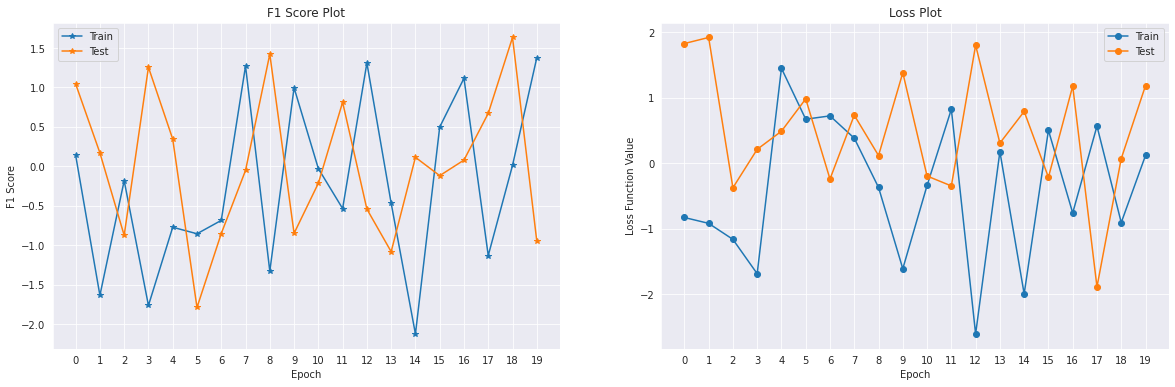

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(train_f1_history, '-*', label='Train')
ax[0].plot(val_f1_history, '-*', label='Test')
ax[0].set_title('F1 Score Plot')
ax[0].set_xticks(range(num_epochs))
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('F1 Score')
ax[0].legend()

ax[1].plot(train_loss_history, '-o', label='Train');
ax[1].plot(val_loss_history, '-o', label='Test');
ax[1].set_title('Loss Plot')
ax[1].set_xticks(range(num_epochs))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Function Value')
ax[1].legend();

In [ ]:
nb_classes = len(classes)
model = model.cpu()
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, tgt in test_dl:
        outputs = model(inputs)
        outputs = softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(tgt.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=confusion_matrix, annot=True)